Notebook Linear Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data: de target is beter doen dan r² = 80% nauwkeurigheid die in de meeste uitwerkingen zit...
- Ook door andere vormen van regressie toe te passen, het doel is om r² zo goed mogelijk te krijgen

==> Resultaat: r² = 86% en 27% fout marge 


Extra:
- er wordt logging voorzien voor en na de belangrijke stappen (zie LinReg_logging.log). Hiermee kunnen de stappen en de resultaten opgevolgd worden. Dit wordt in de LinReg_logging weg geschreven
- we hebben een aantal herbruikbare code-blokken in een functie gestoken
- een aparte class gemaakt voor BinaryValueEncoders om eens te proberen (kan uiteraard met de OneHotEncoder)
- we hebben een functie geschreven om snel een reeks van modellen te kunnen evalueren, zowel zonder pipelining als met pipelining

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance/data

Metadata :
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- data summarizen via summarytools 
- missing en duplicated data oplossen 
- incorrect types controleren
- numerische waarde standardizeren
- categorische varaiabelen processen
- feature engineering
- linear, ridge, lasso, gradient boost, random forest,...
- alle modellen toegepast op 2 situaties voor stratefy
    - Train_test_split zonder stratify
    - Train_test_split met stratefy op basis van de categorisatie van de charges (target v) (omdat er skewness is op charges )

- zowel met pipelining als zonder pipelining uitgewerkt





In [ ]:
# import van de diverse modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import  mean_absolute_percentage_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

# system utils
import warnings
from pathlib import Path
import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info:
- logging functie om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
- log_info_write_to_file: schrijf de loginformatie naar file 
- log_info_print_on_screen: print alle loginfo naar het scherm

In [101]:
# enkele extra code snippets gebruikt doorheen de oefening

plot_graphs = False

# schrijf een visual naar file
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# functies om te loggen naar file
# Lezen van de JSON-file
log_info_lijst = []

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)

def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

In [102]:
# maak een boxplot van een kolommen
# df_num_col is een list van de kolomnamen die geplot worden

def plot_boxplot(df, df_col, filenaam):
    if plot_graphs:
        # boxplot van de numerische waarden
        sns.set_theme(style="whitegrid", palette="bright")
        plt.figure(figsize=(15, 15)) 
        for i, col in enumerate(df_col):
            plt.subplot(len(df_col), 2, 2 * i + 1)
            sns.boxplot(x=df[col], orient='h', linewidth=1.5)
            plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)

            plt.subplot(len(df_col), 2, 2 * i + 2)
            sns.histplot(df[col], kde=True,  linewidth=1)
            plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Density", fontsize=10)

        plt.tight_layout()
        save_fig(filenaam)
        plt.show()

In [103]:
from sklearn.ensemble import IsolationForest

# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df_intern = df.copy()
    df_intern['outlier'] = labels
    outliers = df_intern[df_intern['outlier'] == -1]
    aantal_outliers = df_intern['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df_intern)) * 100

    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df_input, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df_input[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df_output = df_input.copy()
    df_output[column] = np.where(df_input[column] < lower_bound, lower_bound, df_input[column])
    df_output[column] = np.where(df_input[column] > upper_bound, upper_bound, df_input[column])    
    return df_output


# hulp klasse om categorische waarden met twee mogelijke waarde naar 0 en 1 om te zetten
# try-out om zelf eens een  encoder te schrijven
# kan uiteraard eenvoudiger door OneHotEncoding toe te passen

class BinaryValueEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, string_zero="nul", string_one="een"):
        # Je kunt hier extra initialisatie toevoegen indien nodig
        self.string_zero = string_zero
        self.string_one = string_one
     

    def fit(self, X, y=None):
        # Er is geen fitting nodig voor deze eenvoudige codering
        return self

    def transform(self, X):
        # X wordt aangenomen een pandas DataFrame te zijn
        log("Info", f"BinaryValueEncoder transform opgeroepen voor One_value {self.string_one} en Zero_value {self.string_zero}")
        X = X.copy()  # Kopieer de DataFrame om wijzigingen te voorkomen in het origineel
        X = X.applymap(lambda x: 1 if x == self.string_zero else 0)
        return X


def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


    if not hasattr(BinaryValueEncoder, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = BinaryValueEncoder.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        BinaryValueEncoder.__init__ = __init__
        BinaryValueEncoder.get_feature_names_out = get_feature_names_out


monkey_patch_get_signature_names_out()


Monkey-patching FunctionTransformer.get_feature_names_out()


In [104]:
# data bestand inlezen

insurance_data_filename = 'data/insurance.csv'
df = pd.read_csv(insurance_data_filename)
log_info(f"File {insurance_data_filename}")

# check op duplicates, indien zo verwijder direct
df.drop_duplicates(inplace=True)
df_original = df.copy()
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates na drop \n{duplicate_waarden}")

# behoudt een copie van de orginele data
df_original = df.copy()

10/02/2025 16:42:30 : Info : File data/insurance.csv
10/02/2025 16:42:30 : Info : Check op duplicates na drop 
0


In [105]:
# enkele eenvoudige controles
log_info(f"df.info : \n{df.info()}")
log_info(f"df.describe : \n{df.describe()}")

# geen nulwaarden 
from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB
10/02/2025 16:42:30 : Info : df.info : 
None
10/02/2025 16:42:30 : Info : df.describe : 
               age          bmi     children       charges
count  1337.000000  1337.000000  1337.000000   1337.000000
mean     39.222139    30.663452     1.095737  13279.121487
std      14.044333     6.100468     1.205571  12110.359656
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.290000     0.000000   4746.344000
50%      39.000000    30.400000     1.0000

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 39.2 (14.0)min < med < max:18.0 < 39.0 < 64.0IQR (CV) : 24.0 (2.8),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoElEQVR4nO3czYraUBiH8ffUUeMHCSLozhsodOEyF9GL7SXMwivwDtwNiERMJxhjurJQhvqRUyf5p89v3STD4eGYHOjryrI0oOm+1P0HAPd4ufUPnHMDM+tVvP+xLMv3itcCv10N1Tk3mE6n38MwnFS5+X6/3znnfhArfN3aUXthGE7iOH6Poih75MZJkgSr1Wqy3W57Zkao8HLzp9/MLIqibDab/axw/0GFa4AP+JiCBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhLv+cx8+j+ccBbOWzlJ4aqhFUXTNLHTOVb1FKxf9b3znKJi1d5bC00JN07Sb5/m3xWLR6XQ6D80EuFBddI9dMRyPx7M4jvePzlEwa/cshaeFejweX4IgGC6Xy2w+n+8evV510X12xTzPg6Iovvb7/deKcxTMWjpL4envqKPRqOrwCjOPRa/xXa/ydJnNZjNZr9fD0+nUqfBcb01+P27lx1QT3vWqTJfZ7Xa17YZNWLNrWhmqeexqZrqvHZ4avWZtDdXMvGZmmbX0Xe+Wpq4ZB/6Q0Ood9X/kcXYdns/nbk3PNrvxIdboUOtcdEU+Z9eXo7Esy17N7OGfft9z81sfYo0Ntc5FV+Vzdu17NObz7Hs+xBobap2Lbqa9m1c5u/5XR2Me5+ZXn9/YUC/qWHR28+ZpfKh1qHs3x0eEekWdP6H4E+eokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokHDX7KkkSYJHb3w4HAIzszRNg7e3t+FnXq/6bNW/2/f6e/r6BauitLe+44WQAAAAAElFTkSuQmCC"">",0(0.0%)
2,sex[object],1. male2. female,675 (50.5%)662 (49.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,bmi[float64],Mean (sd) : 30.7 (6.1)min < med < max:16.0 < 30.4 < 53.1IQR (CV) : 8.4 (5.0),548 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClElEQVR4nO3dQY7aMBSA4ecyoABSIkQFOy5QqQuWHKKH7RGKxAm4ATukKAoiJSKEdFexGDEQO4Of5//2AS9+IWxsbJqmEcB33149AOARb68eQFeMMUMRGVi8xLlpmpOr8cBOkKEaY4bT6fRXHMeTtq9xOBwyY8xvYvVDkKGKyCCO48lqtTolSVI++3Ce59Fms5mkaToQEUL1QKihiohIkiTlbDb72/LxodPBwAqTKahAqFCBUKFC0N9RbdR13ReR2BjT5nGWthwj1HcURdGvqurnYrHo9Xq9p1cNWNpyj1DfcT6f36IoGi2Xy3I+n2fPPMvSVjcI9Y7xeNx2eYulLceYTEEFQoUKhAoVCBUqECpUIFSoQKhQwet1VItd+vH1eu27Hg9ex9tQbXbpV1UV1XX9oyzLPyLSdj8qPOJtqGKxS3+320222+3ocrn0uhocPpfPoYpIu136WZbxE2ZgmExBBUKFCoQKFQgVKng/mdKIYyzuEapjHGPpBqE6xjGWbhBqRzjG4haTKahAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQodOfUC3veuIkKf7rLFTbu544SYpbXX6iWt31xElS3Op891Tbu544SYpbTKagAqFCBUKFCuzw94zlwUCRQA8HEqpHbA8GioR7OJBQPWJzMFAk7MOBhOohi4OBIoEeDmQyBRUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoV+GUqMKH+2/WHoXLNox4h/9v13VC55lGXkP/t+qNPVK55VCjEf7t+6Dsq1zx+DT5v2mYyBRHxf9M2oUJE3GzaXq/XszRNvxtjDm2GcC/wh0LN8zx69l2Px2MkIlIURbTf70ef+bzW9/Zh3G2dTqdOVxz+AU+4nv9BXK0JAAAAAElFTkSuQmCC"">",0(0.0%)
4,children[int64],1. 02. 13. 24. 35. 46. 5,573 (42.9%)324 (24.2%)240 (18.0%)157 (11.7%)25 (1.9%)18 (1.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dQU7bUBiF0T9RRJuJowiJZbCALKKL7SKygOwDRXjQUCbpoJTSDoCBfZ9lnzNj9pA+vciRr7K6Xq8FCevWB2A5xEaM2IgRGzGrqtpW1U3rg0zA8/V6vbQ+xJxtbm9vv3Vdt299kNb6vj+vVqvvghvPpuu6/eFwuOx2u6fWh2nl8fHx6/F43D88PNxUldhGsqmq2u12T3d3dz9aH6axbesDzJ0HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1+xWb1gdpaen/f8qm7/vz8Xjc18Jfsen7/lxVz63PMWdeC//La+EjWxkpkzLlm81NMzOTHbwYoMzPJAcvBijzNOXBy6KfjufIl7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozY

In [106]:
# drie categorische features: smoking, region en sex
# vier numerische features waaronder de target variabele "charges"
# maak de datasets aan 

df_cat_col = ['smoker','region','sex']
df_num_col = ['age', 'bmi','children']
df_label_col = ['charges']

# zijn er nominaal categorische variabelen en één ordinal categorische waarden?
df_cat_nom_col = ['smoker','region']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

In [107]:
# korte analyze van de categorische variabelen
print(df_cat.value_counts())

# check op nullen
nul_waarden = df.isnull().sum()
log_info(f"Check op nulwaarden \n{nul_waarden}")
# geen nullen




smoker  region     sex   
no      southwest  female    141
        southeast  female    139
        northwest  female    135
        southeast  male      134
        northeast  female    132
        northwest  male      131
        southwest  male      126
        northeast  male      125
yes     southeast  male       55
        northeast  male       38
        southwest  male       37
        southeast  female     36
        northwest  male       29
                   female     29
        northeast  female     29
        southwest  female     21
Name: count, dtype: int64
10/02/2025 16:42:31 : Info : Check op nulwaarden 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [108]:
plot_boxplot(df, df_num_col,"Boxplot en histogram van de numerische waarden")

In [109]:
plot_boxplot(df, df_label_col,"Boxplot en histogram van de target value")

In [110]:
if plot_graphs:
    sns.set_theme(style="whitegrid", palette="bright")
    plt.figure(figsize=(15, len(df_cat_col) * 2))  

    for i, col in enumerate(df_cat_col):
        plt.subplot(1, len(df_cat_col), i + 1)
        sns.countplot(x=col, data=df, palette='bright')
        plt.title(f"Count Plot of {col}", fontsize=14, fontweight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)

    plt.tight_layout()
    save_fig("Categorische features countplot")
    plt.show()
    log_info("Check van categorische features")

In [111]:
if plot_graphs:
    sns.set_theme(style="whitegrid", palette="bright")
    plt.figure(figsize=(15, len(df_cat_col) * 2))  

    for i, col in enumerate(df_cat_col):
        plt.subplot(1, len(df_cat_col), i + 1)
        sns.countplot(x=col, data=df, palette='bright', hue='smoker')
        plt.title(f"Count Plot of {col} (Hue: Smoker)", fontsize=14, fontweight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)

    plt.tight_layout()
    save_fig("Categorische variabelen tov smoker")
    plt.show()

In [112]:
if plot_graphs:
    sns.pairplot(df, hue='smoker',  kind='reg')
    plt.tight_layout()
    save_fig("Numerische features onderlinge scatter")
    plt.show()

C:\Users\geert\AppData\Local\Temp\ipykernel_38388\1097325282.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dataset['sex'] = Dataset['sex'].replace(['male','female'],[0,1])
C:\Users\geert\AppData\Local\Temp\ipykernel_38388\1097325282.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dataset['smoker'] = Dataset['smoker'].replace(['yes','no'],[1,0])
C:\Users\geert\AppData\Local\Temp\ipykernel_38388\1097325282.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To re

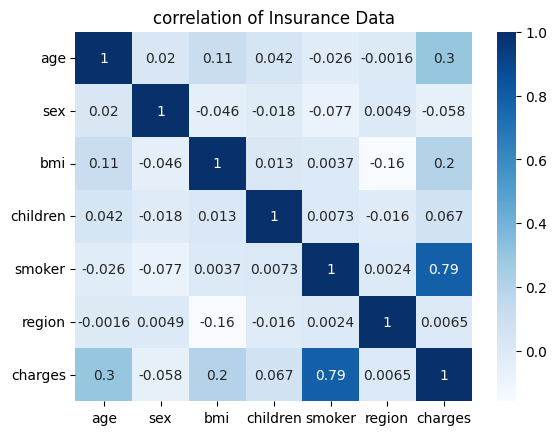

In [113]:
# print de correlation nog af tussen de numerische waarden

if plot_graphs:
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid", palette="bright")
    sns.heatmap(df[df_num_col].corr(), annot=True, cmap='Reds')
    save_fig("Numerische features correlatie")
    plt.show()


Dataset = df.copy()
Dataset['sex'] = Dataset['sex'].replace(['male','female'],[0,1])
Dataset['smoker'] = Dataset['smoker'].replace(['yes','no'],[1,0])
Dataset['region'] = Dataset['region'].replace(['southwest','southeast','northwest','northeast'],[0,1,2,3])

sns.heatmap(Dataset.corr(),annot=True,cmap='Blues')
plt.title('correlation of Insurance Data')
plt.show()

In [114]:
def verwijder_outliers(df_input, df_input_col):
    # Bereken de outliers
    percentage_aantal_outliers = bereken_percentage_aantal_outliers(df_input, df_input_col)
    print(percentage_aantal_outliers)
    log_info(f"Check op de outliers in kolom {df_input_col} : {percentage_aantal_outliers}")

    df_output = df_input.copy()
    for col in df_input_col:
        df_output = cap_values(df_output, col)    

    percentage_aantal_outliers = bereken_percentage_aantal_outliers(df_output, df_input_col)
    print(percentage_aantal_outliers)
    # plot_boxplot(df, df_num_col,"Boxplot en histogram na removing van de outliers")
    log_info(f"Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : {percentage_aantal_outliers}")
    log_info("Capping wordt niet toegepast op de dataset")

    return df_output

plot_boxplot(df_original, df_num_col,"Boxplot en histogram na removing van de outliers")
df_zonder_outliers = verwijder_outliers(df_original,['bmi'])
plot_boxplot(df_zonder_outliers, df_num_col,"Boxplot en histogram na removing van de outliers")




outlier
 1    1074
-1     263
Name: count, dtype: int64
19.670905011219148
10/02/2025 16:42:31 : Info : Check op de outliers in kolom ['bmi'] : 19.670905011219148
10/02/2025 16:42:31 : Info : Capping values voor kolom bmi naar lower percentiel 25 - upper percentiel 75
outlier
 1    1030
-1     307
Name: count, dtype: int64
22.961854899027674
10/02/2025 16:42:31 : Info : Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : 22.961854899027674
10/02/2025 16:42:31 : Info : Capping wordt niet toegepast op de dataset


In [115]:
# Feature preparation
# standard scaler op de numerische waarden, min-max scaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer



num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

#set_matplotlib_closeV_encoder = BinaryValueEncoder("male","female")
#set_matplotlib_smoking_encoder = BinaryValueEncoder("yes","no")
# bv_encoder = PredefinedBinaryCategoricalEncoder(positive_class='female')

male_female_transformer = Pipeline(steps=[
     #('male_female_encoder', BinaryValueEncoder("male","female"))
    ('male_female_encoder', OneHotEncoder(drop='first'))
])

smoking_transformer = Pipeline(steps=[
    #('smoking_encoder', BinaryValueEncoder("yes","no"))
    ('smoking_encoder', OneHotEncoder(drop='first'))
])

regio_transformer = Pipeline(steps=[
    ('regio', OneHotEncoder(drop='first', handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, df_num_col),
    ("male_female", male_female_transformer, ['sex']), 
    ("smoker", smoking_transformer, ['smoker']), 
    ("regio", regio_transformer, ['region'])],
     remainder='passthrough')

df_features = df_original.drop(['charges'], axis= 1)
np_prepared =  preprocessing.fit_transform(df_features)

# really hacking !!! get_feature_names werkt nog niet correct !!! not used now
df_prepared_col = ['age', 'bmi','children','sex','smoker','northeast','northwest','southeast','southwest']

df_prepared = pd.DataFrame(
    np_prepared,
    #columns=preprocessing.get_feature_names_out(),
    columns = [name.split('__')[-1] for name in preprocessing.get_feature_names_out()],
    #columns = df_prepared_col,
    index=df_original.index)

df_prepared.head()

plot_boxplot(df_prepared,df_num_col,"Boxplot van numerische waarden na standard scaling")




In [116]:
def excute_regression_models(X_train, X_test, y_train,y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1) ,
        'Ridge': Ridge(alpha=0.01) ,
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42), 
        'Decision Tree': DecisionTreeRegressor(random_state=42), 
        'XGBRegressor': XGBRegressor(random_state=42)
    }

    results = []
    for name, model in models.items():
        # Cross validation
        mean_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
        mean_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()      

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append([name, mean_rmse, mean_r2, test_rmse, test_r2, test_mape])
    df = pd.DataFrame(results, columns=['model', 'mean_rmse', 'mean_r2', 'test_rmse', 'test_r2', 'test_mape"'])

    return df


In [117]:
def excute_regression_models_with_pipeline(X_train, X_test, y_train,y_test,preprocessor):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1) ,
        'Ridge': Ridge(alpha=0.01) ,
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42), 
        'Decision Tree': DecisionTreeRegressor(random_state=42), 
        'XGBRegressor': XGBRegressor(random_state=42)
    }

    results = []
    for name, model in models.items():        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('regressor', model)
        ])

        pipeline
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_pred)

        results.append([name, test_rmse, test_r2, test_mape])
    df = pd.DataFrame(results, columns=['model', 'test_rmse', 'test_r2', 'test_mape'])

    return df


In [118]:
X = df_prepared.copy()
y = df_original['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultaat_eenvoudig = excute_regression_models(X_train, X_test, y_train, y_test)
print(resultaat_eenvoudig)
log_info("")
log_info("Regression models with no stratefy")
log_info(resultaat_eenvoudig)
log_info("")

               model    mean_rmse   mean_r2    test_rmse   test_r2  test_mape"
0  Linear Regression  6126.274424  0.725757  5956.342894  0.806929    0.413968
1              Lasso  6126.263748  0.725758  5956.469620  0.806920    0.413981
2              Ridge  6126.264010  0.725759  5956.496425  0.806919    0.413992
3      Random Forest  4956.997994  0.820776  4713.964344  0.879071    0.376728
4  Gradient Boosting  4770.832863  0.834189  4268.715369  0.900836    0.315129
5      Decision Tree  6700.088280  0.669360  5850.383924  0.813737    0.348618
6       XGBRegressor  5267.275726  0.797652  5058.168538  0.860766    0.418510
10/02/2025 16:42:36 : Info : 
10/02/2025 16:42:36 : Info : Regression models with no stratefy
10/02/2025 16:42:36 : Info :                model    mean_rmse   mean_r2    test_rmse   test_r2  test_mape"
0  Linear Regression  6126.274424  0.725757  5956.342894  0.806929    0.413968
1              Lasso  6126.263748  0.725758  5956.469620  0.806920    0.413981
2       

In [119]:

X = df_prepared.copy()
y = df_original['charges']
df = df_original.copy()
df["charges_cat"] = pd.cut(df["charges"], bins=[0, 20000,30000, np.inf], labels=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df["charges_cat"] , test_size=0.2, random_state=42)
resultaat_eenvoudig = excute_regression_models(X_train, X_test, y_train, y_test)

print(resultaat_eenvoudig)
log_info("Stratify on charges_cat: extra feature engineering: charges omzetten naar categories : bins=[0, 20000, 30000, np.inf")
log_info("Regresison models with stratefy")
log_info("")
log_info(resultaat_eenvoudig)
log_info("")



               model    mean_rmse   mean_r2    test_rmse   test_r2  test_mape"
0  Linear Regression  5979.658579  0.746402  6528.468489  0.720580    0.433419
1              Lasso  5979.644417  0.746403  6528.395298  0.720587    0.433406
2              Ridge  5979.659844  0.746403  6528.458949  0.720581    0.433432
3      Random Forest  4860.187221  0.828854  5174.453301  0.824465    0.327442
4  Gradient Boosting  4564.451766  0.849529  4784.958831  0.849897    0.279509
5      Decision Tree  6602.793810  0.689389  6802.481743  0.696633    0.345832
6       XGBRegressor  5320.863800  0.794828  5329.730074  0.813772    0.342767
10/02/2025 16:42:40 : Info : Stratify on charges_cat: extra feature engineering: charges omzetten naar categories : bins=[0, 20000, 30000, np.inf
10/02/2025 16:42:40 : Info : Regresison models with stratefy
10/02/2025 16:42:40 : Info : 
10/02/2025 16:42:40 : Info :                model    mean_rmse   mean_r2    test_rmse   test_r2  test_mape"
0  Linear Regression  5

In [120]:

X = df_original.drop(['charges'], axis=1)
y = df_original['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
resultaat_eenvoudig = excute_regression_models_with_pipeline(X_train, X_test, y_train, y_test, preprocessing)

print(resultaat_eenvoudig)
log_info("")
log_info("Regression models with polynomial features, no stratefy")
log_info(resultaat_eenvoudig)
log_info("")


               model    test_rmse   test_r2  test_mape
0  Linear Regression  5956.342894  0.806929   0.413968
1              Lasso  5956.469554  0.806920   0.413981
2              Ridge  5956.496377  0.806919   0.413992
3      Random Forest  4729.965694  0.878249   0.392427
4  Gradient Boosting  4268.283018  0.900856   0.315065
5      Decision Tree  5912.108673  0.809786   0.388309
6       XGBRegressor  5007.415968  0.863546   0.415894
10/02/2025 16:42:53 : Info : 
10/02/2025 16:42:53 : Info : Regression models with polynomial features, no stratefy
10/02/2025 16:42:53 : Info :                model    test_rmse   test_r2  test_mape
0  Linear Regression  5956.342894  0.806929   0.413968
1              Lasso  5956.469554  0.806920   0.413981
2              Ridge  5956.496377  0.806919   0.413992
3      Random Forest  4729.965694  0.878249   0.392427
4  Gradient Boosting  4268.283018  0.900856   0.315065
5      Decision Tree  5912.108673  0.809786   0.388309
6       XGBRegressor  5007.4159

In [92]:
X = df_original.drop(['charges'], axis=1)
y = df_original['charges']

df = df_original.copy()
df["charges_cat"] = pd.cut(df["charges"], bins=[0, 20000,30000, np.inf], labels=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df["charges_cat"] , test_size=0.2, random_state=42)
resultaat_eenvoudig = excute_regression_models_with_pipeline(X_train, X_test, y_train, y_test, preprocessing)

print(resultaat_eenvoudig)
log_info("")
log_info("Stratify on charges_cat: extra feature engineering: charges omzetten naar categories : bins=[0, 20000, 30000, np.inf")
log_info("Regression models polynomial features en stratify on charges_cat")
log_info(resultaat_eenvoudig)
log_info("")

               model    test_rmse   test_r2  test_mape"
0  Linear Regression  6528.468489  0.720580    0.433419
1              Lasso  6528.395243  0.720587    0.433406
2              Ridge  6528.458919  0.720581    0.433432
3      Random Forest  5173.584333  0.824524    0.325311
4  Gradient Boosting  4784.958831  0.849897    0.279509
5      Decision Tree  6802.446036  0.696636    0.345666
6       XGBRegressor  5380.070126  0.810238    0.355567
10/02/2025 16:19:29 : Info : 
10/02/2025 16:19:29 : Info : Stratify on charges_cat: extra feature engineering: charges omzetten naar categories : bins=[0, 20000, 30000, np.inf
10/02/2025 16:19:29 : Info : Regression models polynomial features en stratify on charges_cat
10/02/2025 16:19:29 : Info :                model    test_rmse   test_r2  test_mape"
0  Linear Regression  6528.468489  0.720580    0.433419
1              Lasso  6528.395243  0.720587    0.433406
2              Ridge  6528.458919  0.720581    0.433432
3      Random Forest  5173.58

In [93]:
log_info_write_to_file("LinReg_logging.log")